In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from geopy.geocoders import Nominatim
from pathlib import Path

# Context
- This data comes from the Bigfoot Field Researchers Organization (BFRO), which is dedicated to discovering the truth of Bigfoot's existence.
- The dataset has information about sightings (a text description of the report and a classification), geocoded location data, timestamps, and supplemental weather data from the Dark Sky API.
- [Classification types from the BFRO](https://www.bfro.net/gdb/classify.asp)
    - Class A = low likelihood of misidentification
    - Class B = Observed with big distance/bad lighting/only heard
    - Class C = second-hand/third-hand reports or w/ untraceable sources
- (1) bfro_report_locations - a table view displaying geocoded reports
- (2) bfro_reports - full text reports in line delimited JSON format
- (3) bfro_reports_geocoded - combining & cleaning the report locations along with full text reprots plus weather conditions on day of sighting.
- Each file has been collected on 4/17/19 & updated 8/28/21 respectively

In [2]:
locations_df = pd.read_csv('data/bfro_locations.csv')
reports_df = pd.read_csv('data/bfro_reports.csv')
geocoded_df = pd.read_csv('data/bfro_reports_geocoded.csv')

# BFRO Locations
- 4250 non-null rows
- Column Descriptions:
    - number: The report number of the sighting. (Integer)
    - title: The title of the sighting report. (String)
    - classification: The classification of the sighting. (String)
    - timestamp: The date and time of the sighting. (DateTime)
    - latitude: The latitude of the sighting. (Float)
    - longitude: The longitude of the sighting. (Float) 
- Transformations:
    - Converted 'timestamp' from an object to a datetime
    - Some longitude values were clearly too large (e.g. -9.486840e+07) and were set to values with the decimal after two places.
    - One-hot encoding for classification for correlation
- Insights:
    - There is no significant correlation between classification and latitude/longitude


In [3]:
locations_df

,index,number,title,classification,timestamp,latitude,longitude
0,0,637,Report 637: Campers' encounter just after dark...,Class A,2000-06-16T12:00:00Z,61.50000,-142.90000
1,1,2917,Report 2917: Family observes large biped from car,Class A,1995-05-15T12:00:00Z,55.18720,-132.79820
2,2,7963,Report 7963: Sasquatch walks past window of ho...,Class A,2004-02-09T12:00:00Z,55.20350,-132.82020
3,3,9317,"Report 9317: Driver on Alcan Highway has noon,...",Class A,2004-06-18T12:00:00Z,62.93750,-141.56670
4,4,13038,Report 13038: Snowmobiler has encounter in dee...,Class A,2004-02-15T12:00:00Z,61.05950,-149.78530
...,...,...,...,...,...,...,...
4245,4245,4159,Report 4159: Campers hear unusual grunting sou...,Class C,1995-11-15T12:00:00Z,31.22333,-94.96611
4246,4246,175,Report 175: Campers encounter large animal nea...,Class C,2000-07-30T12:00:00Z,47.47745,-121.04150
4247,4247,945,Report 945: Creature with red glowing eyes seen,Class C,1999-03-19T12:00:00Z,47.57778,-124.29330
4248,4248,1387,Report 1387: Father and son hear heavy footste...,Class C,1983-08-17T12:00:00Z,47.51030,-122.04560


In [4]:
locations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           4250 non-null   int64  
 1   number          4250 non-null   int64  
 2   title           4250 non-null   object 
 3   classification  4250 non-null   object 
 4   timestamp       4250 non-null   object 
 5   latitude        4250 non-null   float64
 6   longitude       4250 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 232.5+ KB


In [5]:
locations_df.describe()

,index,number,latitude,longitude
count,4250.000000,4250.000000,4250.000000,4.250000e+03
mean,2124.500000,22586.533647,39.831850,-6.684490e+04
std,1227.013651,19015.127478,6.009091,2.028967e+06
min,0.000000,60.000000,25.141000,-9.486840e+07
25%,1062.250000,6923.750000,35.629365,-1.180889e+02
50%,2124.500000,17230.500000,39.633185,-9.235350e+01
75%,3186.750000,34236.000000,44.824168,-8.316599e+01
max,4249.000000,71997.000000,64.891390,-6.383683e+01


In [6]:
locations_df['longitude'][locations_df['longitude'] < -180]

1167    -3706646.0
1586    -4319942.0
2067      -79625.0
2978   -36588780.0
3139   -94868400.0
3407   -40544270.0
3457   -40757860.0
3995   -61921560.0
4161     -446665.2
4164     -442106.6
Name: longitude, dtype: float64

In [7]:
locations_df.at[1167, 'longitude'] = -37.06646
locations_df.at[1586, 'longitude'] = -43.19942
locations_df.at[2067, 'longitude'] = -79.625
locations_df.at[2978, 'longitude'] = -36.588780
locations_df.at[3139, 'longitude'] = -94.868400
locations_df.at[3407, 'longitude'] = -40.544270
locations_df.at[3457, 'longitude'] = -40.757860
locations_df.at[3995, 'longitude'] = -61.921560
locations_df.at[4161, 'longitude'] = -44.6665
locations_df.at[4164, 'longitude'] = -44.2106

In [8]:
locations_df.describe()

,index,number,latitude,longitude
count,4250.000000,4250.000000,4250.000000,4250.000000
mean,2124.500000,22586.533647,39.831850,-97.761034
std,1227.013651,19015.127478,6.009091,17.093641
min,0.000000,60.000000,25.141000,-167.131000
25%,1062.250000,6923.750000,35.629365,-117.976150
50%,2124.500000,17230.500000,39.633185,-92.308965
75%,3186.750000,34236.000000,44.824168,-83.114762
max,4249.000000,71997.000000,64.891390,-36.588780


<Axes: xlabel='latitude', ylabel='Count'>

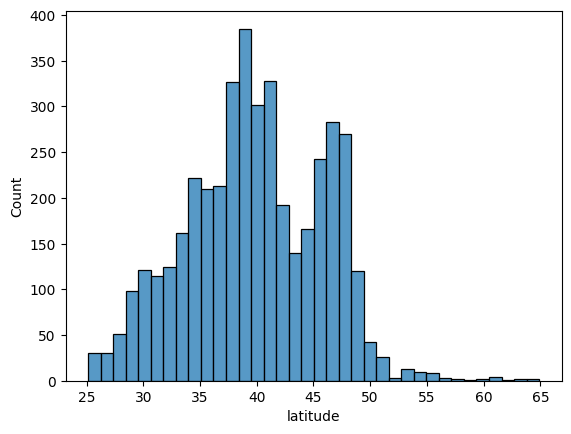

In [9]:
sns.histplot(locations_df['latitude'])

<Axes: xlabel='longitude', ylabel='Count'>

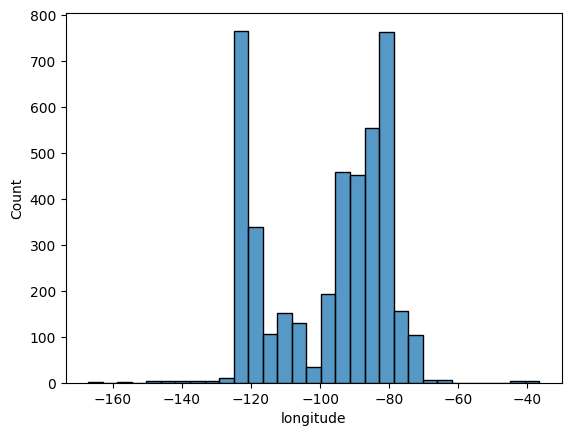

In [10]:
sns.histplot(locations_df['longitude'])

In [11]:
locations_df['classification'].value_counts()

Class B    2138
Class A    2093
Class C      19
Name: classification, dtype: int64

In [12]:
locations_df['timestamp'] = pd.to_datetime(locations_df['timestamp'])

<Axes: xlabel='longitude', ylabel='latitude'>

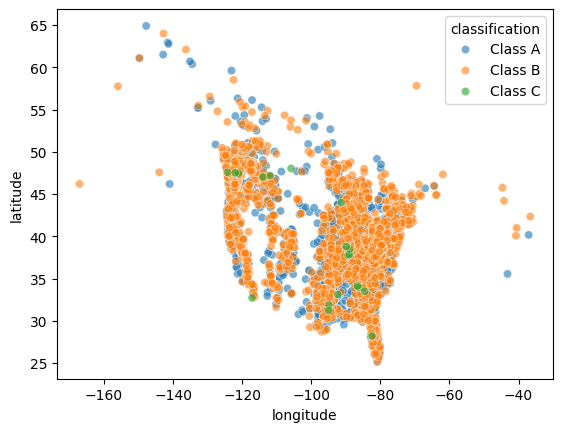

In [13]:
sns.scatterplot(x=locations_df['longitude'], y=locations_df['latitude'], hue=locations_df['classification'], alpha=0.6)

In [14]:
def one_hot_encode(data, col_name):
    data = pd.concat([data, pd.get_dummies(data[col_name], dtype=int)], axis=1)
    data.drop(col_name, axis=1, inplace=True)
    return data

In [15]:
locations_df = one_hot_encode(locations_df, 'classification')
locations_df

,index,number,title,timestamp,latitude,longitude,Class A,Class B,Class C
0,0,637,Report 637: Campers' encounter just after dark...,2000-06-16 12:00:00+00:00,61.50000,-142.90000,1,0,0
1,1,2917,Report 2917: Family observes large biped from car,1995-05-15 12:00:00+00:00,55.18720,-132.79820,1,0,0
2,2,7963,Report 7963: Sasquatch walks past window of ho...,2004-02-09 12:00:00+00:00,55.20350,-132.82020,1,0,0
3,3,9317,"Report 9317: Driver on Alcan Highway has noon,...",2004-06-18 12:00:00+00:00,62.93750,-141.56670,1,0,0
4,4,13038,Report 13038: Snowmobiler has encounter in dee...,2004-02-15 12:00:00+00:00,61.05950,-149.78530,1,0,0
...,...,...,...,...,...,...,...,...,...
4245,4245,4159,Report 4159: Campers hear unusual grunting sou...,1995-11-15 12:00:00+00:00,31.22333,-94.96611,0,0,1
4246,4246,175,Report 175: Campers encounter large animal nea...,2000-07-30 12:00:00+00:00,47.47745,-121.04150,0,0,1
4247,4247,945,Report 945: Creature with red glowing eyes seen,1999-03-19 12:00:00+00:00,47.57778,-124.29330,0,0,1
4248,4248,1387,Report 1387: Father and son hear heavy footste...,1983-08-17 12:00:00+00:00,47.51030,-122.04560,0,0,1


<Axes: >

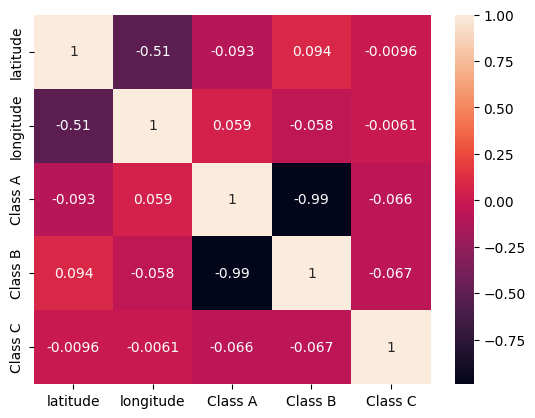

In [16]:
sns.heatmap(locations_df.drop(['index', 'number'], axis=1).corr(numeric_only=True), annot=True)

# BFRO Reports
- 5485 rows, many null entries
- Not doing a full EDA on this part of the data since the bfro_reports_geocoded is an already cleaned version of this
- Column Descriptions:
    - YEAR: Year of the sighting. (Integer)
    - SEASON: Season of the sighting. (String)
    - STATE: State of the sighting. (String)
    - COUNTY: County of the sighting. (String)
    - NEAREST_TOWN: Nearest town to the sighting. (String)
    - NEAREST_ROAD: Nearest road to the sighting. (String)
    - OBSERVED: Description of what was observed. (String)
    - ALSO_NOTICED: Any other details noticed during the sighting. (String)
    - OTHER_WITNESSES: Any other witnesses to the sighting. (String)
    - OTHER_STORIES: Any other stories related to the sighting. (String)
    - TIME_AND_CONDITIONS: Time and conditions of the sighting. (String)
    - ENVIRONMENT: Environment of the sighting. (String)
    - REPORT_NUMBER: Report number of the sighting. (Integer)
    - REPORT_CLASS: Classification of the sighting. (String)
    - LOCATION_DETAILS: Location details of the sighting. (String)
    - MONTH: Month of the sighting. (Integer)
    - DATE: Date of the sighting. (Integer)
    - A_&_G_References: Any references to the sighting. (String)


In [17]:
reports_df

,index,YEAR,SEASON,STATE,COUNTY,NEAREST_TOWN,NEAREST_ROAD,OBSERVED,ALSO_NOTICED,OTHER_WITNESSES,OTHER_STORIES,TIME_AND_CONDITIONS,ENVIRONMENT,REPORT_NUMBER,REPORT_CLASS,LOCATION_DETAILS,MONTH,DATE,A_&_G_References
0,0,2010,Summer,Alabama,Winston County,Double Springs,Highway 33,I was canoeing on the Sipsey river in Alabama....,3 hours before on river while I paused to fix ...,none,"No, but I've had a couple of weird things happ...","Dusk, was a clear day in about the high 80s te...",River running through a very remote forest are...,30680.0,Class B,NaN,NaN,NaN,NaN
1,1,Early 1990's,Fall,Alaska,Valdez-Chitina-Whittier County,NaN,NaN,Ed L. was salmon fishing with a companion in P...,NaN,On a commercial fishing boat at anchor at the ...,NaN,"Early Fall, in the early 1990's.",NaN,1261.0,Class A,East side of Prince William Sound,NaN,NaN,NaN
2,2,1974,Fall,Rhode Island,Washington County,Wakefield,Perry Ave.,"While attending U.R.I in the Fall of 1974,I wo...",none,none,"White gorilla was seen in a gravel pit, by a f...","10:00pm, very dark cool night.","Typical new England. Oak,Pine and Maple trees....",6496.0,Class A,"Great swamp area, Narragansett Indians",September,Sunday,NaN
3,3,72 or 73,Summer,Pennsylvania,York County,York; more specifically Manchester twp.,Raintree Road,"Hello, My name is Doug and though I am very re...",My friend noted that he had spent the night be...,3. Don't remember the name of the third. He wa...,Just noting that my friend spent the night bef...,Incident occured somewhere between the hours o...,NaN,8000.0,Class B,I would rather not have exact location (listin...,NaN,NaN,NaN
4,4,1984,Spring,Oregon,Yamhill County,Yamhill,NW Fairdale,It was May 1984. Two friends and I were up in ...,Not sure. It took me a full 5 years to be able...,There were two other wittness' other than me. ...,NaN,I know that it was May of 1984 because it was ...,Gravel logging road. Very dense fir forests. B...,703.0,Class B,"Logging roads north west of Yamhill, OR, about...",May,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5480,5480,2005,Summer,New Mexico,Rio Arriba County,dulce nm,(withheld),while camping protecting other equipment befor...,no frist time camping there,"one nephew, my two son where sleeping",local people talk off seeing bigfoot in the ar...,"moon was half full, about 0330 hrs. clear skys...","mountain valley, with ridges and canyons, pine...",11992.0,Class B,(withheld),June,"june 26, 2005",NaN
5481,5481,1976,Spring,Maryland,Prince George's County,NaN,NaN,I was on my way to work on a Saturday morning ...,NaN,I was on my way to work around 7 am on a Satur...,NaN,NaN,there is an undeveloped area of land that stra...,1171.0,Class A,"Laurel, Maryland. It was sighted off of Rt 19...",NaN,NaN,NaN
5482,5482,2011,Summer,Florida,Lake County,Sorrento,Mt.Plymouth rd/St.rt.46,On the twenty sixth and again on the twenty se...,NaN,NaN,close by about 20 or so years ago.also a frien...,between 5:00 and 5:15 am,"some houses, some pine forest, this area lies ...",30267.0,Class A,"head n.on highway 441 from Orlando,then go eas...",July,26,NaN
5483,5483,2015,Fall,Illinois,White County,Norris City,Omitted for privacy reasons,I was hunting on me and my neighbor's property...,Trees big around as pipe pvc snapped in half a...,No I was hunting,No,It was right before morning before you could s...,Covered brush deer trail area,59058.0,Class B,It was on my neighbor's property in the woods ...,November,12,NaN


In [18]:
reports_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5485 entries, 0 to 5484
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                5485 non-null   int64  
 1   YEAR                 5020 non-null   object 
 2   SEASON               5021 non-null   object 
 3   STATE                5021 non-null   object 
 4   COUNTY               5021 non-null   object 
 5   NEAREST_TOWN         4699 non-null   object 
 6   NEAREST_ROAD         4321 non-null   object 
 7   OBSERVED             4983 non-null   object 
 8   ALSO_NOTICED         3339 non-null   object 
 9   OTHER_WITNESSES      4551 non-null   object 
 10  OTHER_STORIES        3586 non-null   object 
 11  TIME_AND_CONDITIONS  4539 non-null   object 
 12  ENVIRONMENT          4747 non-null   object 
 13  REPORT_NUMBER        5021 non-null   float64
 14  REPORT_CLASS         5021 non-null   object 
 15  LOCATION_DETAILS     4261 non-null   o

# BFRO Reports Geocoded
- 5021 rows with many null entries except for county, state, season, and classification
- Column Descriptions:
    - title: The title of the sighting report. (String)
    - latitude: The latitude of the sighting. (Float)
    - longitude: The longitude of the sighting. (Float)
    - number: The report number of the sighting. (Integer)
    - classification: The classification of the sighting. (String)
    - observed: The date and time of the sighting. (DateTime)
    - observed: The date and time of the sighting. (DateTime)
    - location_details: The specific location of the sighting. (String)
    - county: The county in which the sighting occurred. (String)
    - state: The state in which the sighting occurred. (String)
    - season: The season in which the sighting occurred. (String)
    - geohash: The geohash of the sighting. (String)
    - temperature_high: The high temperature on the day of the sighting. (Float)
    - temperature_low: The low temperature on the day of the sighting. (Float)
    - dew_point: The dew point on the day of the sighting. (Float)
    - cloud_cover: The cloud cover on the day of the sighting. (Float)
    - moon_phase: The moon phase on the day of the sighting. (String)
    - precip_intensity: The precipitation intensity on the day of the sighting. (Float)
    - precip_probability: The precipitation probability on the day of the sighting. (Float)
    - precip_type: The type of precipitation on the day of the sighting. (String)
    - pressure: The atmospheric pressure on the day of the sighting. (Float)
    - summary: A summary of the weather conditions on the day of the sighting. (String)
    - visibility: The visibility on the day of the sighting. (Float)
    - wind_bearing: The wind bearing on the day of the sighting. (Integer)
    - wind_speed: The wind speed on the day of the sighting. (Float)


In [19]:
geocoded_df

,index,observed,location_details,county,state,season,title,latitude,longitude,date,...,moon_phase,precip_intensity,precip_probability,precip_type,pressure,summary,uv_index,visibility,wind_bearing,wind_speed
0,0,I was canoeing on the Sipsey river in Alabama....,NaN,Winston County,Alabama,Summer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Ed L. was salmon fishing with a companion in P...,East side of Prince William Sound,Valdez-Chitina-Whittier County,Alaska,Fall,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"While attending U.R.I in the Fall of 1974,I wo...","Great swamp area, Narragansett Indians",Washington County,Rhode Island,Fall,Report 6496: Bicycling student has night encou...,41.45,-71.5,1974-09-20,...,0.16,0.0,0.0,NaN,1020.61,Foggy until afternoon.,4.0,2.75,198.0,6.92
3,3,"Hello, My name is Doug and though I am very re...",I would rather not have exact location (listin...,York County,Pennsylvania,Summer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,It was May 1984. Two friends and I were up in ...,"Logging roads north west of Yamhill, OR, about...",Yamhill County,Oregon,Spring,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,5016,while camping protecting other equipment befor...,(withheld),Rio Arriba County,New Mexico,Summer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5017,5017,I was on my way to work on a Saturday morning ...,"Laurel, Maryland. It was sighted off of Rt 19...",Prince George's County,Maryland,Spring,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5018,5018,On the twenty sixth and again on the twenty se...,"head n.on highway 441 from Orlando,then go eas...",Lake County,Florida,Summer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5019,5019,I was hunting on me and my neighbor's property...,It was on my neighbor's property in the woods ...,White County,Illinois,Fall,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
geocoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               5021 non-null   int64  
 1   observed            4983 non-null   object 
 2   location_details    4261 non-null   object 
 3   county              5021 non-null   object 
 4   state               5021 non-null   object 
 5   season              5021 non-null   object 
 6   title               4045 non-null   object 
 7   latitude            4045 non-null   float64
 8   longitude           4045 non-null   float64
 9   date                4045 non-null   object 
 10  number              5021 non-null   float64
 11  classification      5021 non-null   object 
 12  geohash             4045 non-null   object 
 13  temperature_high    3338 non-null   float64
 14  temperature_mid     3186 non-null   float64
 15  temperature_low     3189 non-null   float64
 16  dew_po

In [21]:
geocoded_df = one_hot_encode(geocoded_df, 'classification')

In [23]:
geolocator = Nominatim(user_agent="Bigfootprint")
long_na = geocoded_df[geocoded_df['longitude'].isna()].copy()

def get_lat_long(geolocator, county_state):
    location = geolocator.geocode(county_state)

    if not location:
        return np.nan, np.nan
    
    return location.latitude, location.longitude

geocoded_df['latitude'], geocoded_df['longitude'] = zip(*long_na[['county', 'state']].agg(', '.join, axis=1)
                                                        .map(lambda county_state: get_lat_long(geolocator, county_state)))

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=La+Salle+County%2C+Illinois&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [ ]:
geocoded_df.to_csv(Path('data/cleaned_csv.csv'), encoding='utf-8', index=False)

In [ ]:
plt.figure(figsize=(16,5))
geocoded_corr = geocoded_df.drop(['index', 'number'], axis=1).corr(numeric_only=True)
sns.heatmap(geocoded_corr, annot=True, mask=np.triu(geocoded_corr))

In [ ]:
plt.figure(figsize=(24,6))
sns.pairplot(geocoded_df.drop(['index', 'number'], axis=1), corner=True)